In [2]:
import pandas as pd
from collections import defaultdict
import numpy as np
from glob import glob
import os
from xmrec.utils import io
import matplotlib.pyplot as plt

In [3]:
metrics_sel = ["ndcg_cut_10"]
params = ["arg_tgt_market", "arg_aug_src_market", "arg_data_sampling_method"]
tgt_markets = ['ca', 'de', 'fr', 'in', 'jp', 'mx', 'uk']
src_markets = tgt_markets + ["us"]

In [4]:
def row_exists(dicts, df, n):
    filt = df
    for k, v in dicts.items():
        filt = filt[filt[k] == v]
        if len(filt) == 0:
            return False
    return len(filt) == n

In [5]:
def row_select(dicts, df):
    filt = df
    for k, v in dicts.items():
        filt = filt[filt[k] == v]
        if len(filt) == 0:
            return None
    return filt

def row_select_single(dicts, df):
    r = row_select(dicts, df)
    assert len(r) == 1, str(r)
    return r.to_dict(orient="records")[0]

def write_row(writer, TGT, row_selection, df):
    for tgt in TGT:
        rr = row_selection.copy()
        rr["arg_tgt_market"] = tgt
        row = row_select(rr, df)
        row = row.to_dict(orient="records")
        assert len(row) == 1
        row = row[0]
        writer.write(f"{row['ndcg_cut_10_mean']:.4f}\t")
        
    
    
method_key = {
    "gmf": "GMF",
    "mlp": "MLP",
    "nmf": "NMF"
}


TGT = "de jp in fr ca mx uk".split()

In [6]:
RESULTS_KEY = ['exp_type', 'method', 'arg_tgt_market', 'arg_aug_src_market', 'arg_data_sampling_method']

def get_key(row, market_aware=False, exclude_src=False):
    if exclude_src:
        key = key = "_".join([row.get(_, "NA") for _ in RESULTS_KEY if _ != "arg_aug_src_market"])
    else:
        key = "_".join([row.get(_, "NA") for _ in RESULTS_KEY])
    if market_aware:
        key += "_market_aware"
    return key

def read_single(folder="raw_results", split="test"):
    folders = ["forec_eval_single/*"]
    results = []
    
    user_level_results = {}
    for fold in folders:
        for file_ in glob(os.path.join(folder, fold)):
            r = io.load_json(file_)
            args = {v: r["args"][v[4:]] for v in params}
            args["exp_type"] = "single"
            for method in ["gmf", "mlp", "nmf"]:
                rr = r[method][split]
                row = args.copy()
                row["method"] = method
                
                
                key = get_key(row)
                
                assert key not in user_level_results
                user_level_results[key] = {}
                
                for met in metrics_sel:
                    mean, std = rr["agg"][met]["mean"], rr["agg"][met]["std"]
                    row[met] = f"{mean:.2f} ({std:.2f})"
                    row[f"{met}_mean"] = rr["agg"][met]["mean"]
                    user_level_results[key][met] = {uid:_[met] for uid,_ in rr["ind"].items()}
                                    
                row["time_taken"] = r[method]["train_time"]
                row["key"] = key
                results.append(row)
    
    return pd.DataFrame(results), user_level_results


    
single, single_user_level = read_single()

for tgt in tgt_markets:
    assert row_exists({"arg_tgt_market": tgt, "method": "gmf"}, single, 1)
    assert row_exists({"arg_tgt_market": tgt, "method": "nmf"}, single, 1)
    assert row_exists({"arg_tgt_market": tgt, "method": "mlp"}, single, 1)
    

In [7]:
def read_forec_base(split="test", folder="raw_results", data_sampling="equal"):
    assert data_sampling in {"equal", "concat"}
    if data_sampling == "equal":
        folders = ["forec_eval_all/base*"]
    else:
        folders = ["forec_eval_all_concat/base*"]
        
    user_level_results = {}
    results = []
    for fold in folders:
        for file_ in glob(os.path.join(folder, fold)):
            r = io.load_json(file_)
            args = {v: r["args"][v[4:]] for v in params}
            args["exp_type"] = "base"
            for method in ["gmf", "mlp", "nmf"]:
                rr = r[method][split]
                row = args.copy()
                row["method"] = method
                
                key = get_key(row)
                assert key not in user_level_results
                user_level_results[key] = {}
                
                for met in metrics_sel:
                    mean, std = rr["agg"][met]["mean"], rr["agg"][met]["std"]
                    row[met] = f"{mean:.2f} ({std:.2f})"
                    row[f"{met}_mean"] = rr["agg"][met]["mean"]
                    user_level_results[key][met] = {uid:_[met] for uid, _ in rr["ind"].items()}
                
                row["time_taken"] = r[method]["train_time"]
                row["key"] = key
                results.append(row)
    
    return pd.DataFrame(results), user_level_results

base_val, _ = read_forec_base(split="valid")


base, base_user_level = read_forec_base()
for tgt in tgt_markets:
    for src in src_markets:
        if src == tgt:
            continue
        for meth in {"gmf", "mlp", "nmf"}:
            assert row_exists({"arg_tgt_market": tgt, "arg_aug_src_market": src, "method": meth}, base, 1), f"tgt: {tgt}, src: {src}, method: {meth}"
            
            assert row_exists({"arg_tgt_market": tgt, "arg_aug_src_market": src, "method": meth}, base_val, 1), f"tgt: {tgt}, src: {src}, method: {meth}"

            

In [8]:
def read_forec_maml(split="test", folder="raw_results", data_sampling="equal"):
    assert data_sampling in {"equal", "concat"}
    if data_sampling == "equal":
        folders = ["forec_eval_all/maml*"]
    else:
        folders = ["forec_eval_all_concat/maml*"]
        
    user_level_results = {}
    results = []
    for fold in folders:
        for file_ in glob(os.path.join(folder, fold)):
            r = io.load_json(file_)
            args = {v: r["args"][v[4:]] for v in params}
            args["exp_type"] = "maml"
            tgt = args["arg_tgt_market"]
            for method in ["nmf"]:
                rr = r[method][f"{split}_{tgt}_step0"]
                row = args.copy()
                row["method"] = f"{method}_maml"
                
                key = get_key(row)
                
                assert key not in user_level_results
                user_level_results[key] = {}
                
                for met in metrics_sel:
                    mean, std = rr["agg"][met]["mean"], rr["agg"][met]["std"]
                    row[met] = f"{mean:.2f} ({std:.2f})"
                    row[f"{met}_mean"] = rr["agg"][met]["mean"]
                    user_level_results[key][met] = {uid:_[met] for uid, _ in rr["ind"].items()}
                
                row["time_taken"] = r[method]["train_time"]
                row["key"] = key
                results.append(row)
    
    return pd.DataFrame(results), user_level_results

maml_val, _ = read_forec_maml(split="valid")
maml, maml_user_level = read_forec_maml()

failures = []
for tgt in tgt_markets:
    for src in src_markets:
        if src == tgt:
            continue
        for meth in {"nmf"}:
            if not row_exists({"arg_tgt_market": tgt, "arg_aug_src_market": src, "method": f"{meth}_maml"}, maml, 1):
                failures.append(f"tgt: {tgt}, src: {src}, method: {meth}")
                            
                
            if not row_exists({"arg_tgt_market": tgt, "arg_aug_src_market": src, "method": f"{meth}_maml"}, maml_val, 1):
                failures.append(f"tgt: {tgt}, src: {src}, method: {meth}")
            
for f in failures:
    print(f)


In [9]:
def read_forec_forec(split="test", folder="raw_results", data_sampling="equal"):
    assert data_sampling in {"equal", "concat"}
    if data_sampling == "equal":
        folders = ["forec_eval_all/forec*"]
    else:
        folders = ["forec_eval_all_concat/forec*"]

    results = []
    user_level_results = {}
    for fold in folders:
        for file_ in glob(os.path.join(folder, fold)):
            r = io.load_json(file_)
            args = {v: r["args"][v[4:]] for v in params}
            args["exp_type"] = "forec"
            tgt = args["arg_tgt_market"]
            r = r[tgt]
            rr = r[split]
            row = args.copy()
            row["method"] = f"forec"
            row["time_taken"] = r["train_time"]
            
            
            key = get_key(row)
            row["key"] = key
            
            assert key not in user_level_results
            user_level_results[key] = {}
            
            for met in metrics_sel:
                mean, std = rr["agg"][met]["mean"], rr["agg"][met]["std"]
                row[met] = f"{mean:.2f} ({std:.2f})"
                row[f"{met}_mean"] = rr["agg"][met]["mean"]
                user_level_results[key][met] = {uid:_[met] for uid, _ in rr["ind"].items()}
                
            results.append(row)
    
    return pd.DataFrame(results), user_level_results

forec_val, _ = read_forec_forec(split="valid")
forec, forec_user_level = read_forec_forec()

failures = []
for tgt in tgt_markets:
    for src in src_markets:
        if src == tgt:
            continue
        if not row_exists({"arg_tgt_market": tgt, "arg_aug_src_market": src, "method": f"forec"}, forec, 1):
            failures.append(f"tgt: {tgt}, src: {src}")
            
        if not row_exists({"arg_tgt_market": tgt, "arg_aug_src_market": src, "method": f"forec"}, forec_val, 1):
            failures.append(f"tgt: {tgt}, src: {src}")
                
print(len(failures))
for f in failures:
    print(f)


0


In [10]:
def compute_avg_mkt(df: pd.DataFrame, group_keys, user_level, market_aware):
    rows = []
    avg_user_level = {}
    for idx, gr in df.groupby(by=group_keys):
        row = {"arg_aug_src_market": "avg"}
        
        for k, v in zip(group_keys, idx):
            row[k] = v

        row["ndcg_cut_10_mean"] = gr["ndcg_cut_10_mean"].mean()
        kk = [get_key(gr.iloc[i], exclude_src=True, market_aware=market_aware) for i in range(len(gr))]
        assert all([kk[0] == k for k in kk])
        group_key = kk[0]
        row["key"] = group_key
        rows.append(row)
        
        
        # met -> {u: [val1, val2, ...]}
        avg = defaultdict(lambda: defaultdict(list))
        for key in gr["key"]:
            for met, u_dict in user_level[key].items():
                for k, v in u_dict.items():
                    avg[met][k].append(v)
        
        
        
        avg_user_level[group_key] = {}
        for met, u_dict in avg.items():
            avg_user_level[group_key][met] = {}
            for k, vv in u_dict.items():
                avg_user_level[group_key][met][k] = np.mean(vv)
            
        
    return pd.DataFrame(rows), avg_user_level
        

In [11]:
base_avg, base_avg_user_level = compute_avg_mkt(base,
                           group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"],
                           user_level=base_user_level,
                           market_aware=False)

maml_avg, maml_avg_user_level = compute_avg_mkt(maml, 
                           group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"],
                           user_level=maml_user_level,
                           market_aware=False)


forec_avg, forec_avg_user_level = compute_avg_mkt(forec, 
                           group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"],
                           user_level=forec_user_level,
                           market_aware=False)


In [12]:
def compute_best_mkt(df_val: pd.DataFrame, df: pd.DataFrame, group_keys):
    
    
    best_markets = []
    
    # find best performing val market per group key
    for idx, gr in df_val.groupby(by=group_keys):
        row = {}
        for k, v in zip(group_keys, idx):
            row[k] = v
        
        gr.sort_values("ndcg_cut_10_mean", ascending=False, inplace=True)
        best_mkt  = gr.iloc[0]["arg_aug_src_market"]
        best_markets.append((best_mkt, row))
    
    # select test perfs
    test_rows = []
    for best_mkt, row in best_markets:
        row["arg_aug_src_market"] = best_mkt
        
        t = row_select_single(row, df)
        
        test_row = dict(row)
        test_row["ndcg_cut_10_mean"] = t["ndcg_cut_10_mean"]
        test_row["key"] = t["key"]
        test_rows.append(test_row)
    
    return pd.DataFrame(test_rows)
    


In [13]:
base_best = compute_best_mkt(df_val=base_val,
                             df=base, 
                             group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"])



maml_best = compute_best_mkt(df_val=maml_val, 
                             df=maml, 
                             group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"])


forec_best = compute_best_mkt(df_val=forec_val, 
                              df=forec, 
                              group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"])


In [14]:
def compute_us_mkt(df: pd.DataFrame, group_keys):
    rows = []
    for idx, gr in df.groupby(by=group_keys):
        row = {}
        us_row = gr[gr["arg_aug_src_market"] == "us"]
        assert len(us_row) == 1
        for k, v in us_row.to_dict(orient="records")[0].items():
            row[k] = v
        rows.append(row)
    return pd.DataFrame(rows)



In [15]:
base_us = compute_us_mkt(base, 
                         group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"])

maml_us = compute_us_mkt(maml,
                         group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"])

forec_us = compute_us_mkt(forec,
                          group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"])


In [16]:
def read_market_aware_base(split="test", folder="raw_results", data_sampling="equal"):
    assert data_sampling in {"equal", "concat"}
    
    if data_sampling == "equal":
        folders = ["forec_eval_all_market_aware/base*"]
    else:
        folders = ["forec_eval_all_market_aware_concat/base*"]
        
    results = []
    user_level_results = {}
    for fold in folders:
        for file_ in glob(os.path.join(folder, fold)):
            r = io.load_json(file_)
            assert r["args"]["market_aware"]
            args = {v: r["args"][v[4:]] for v in params}
            args["exp_type"] = "base"
            
            for method in ["gmf", "mlp", "nmf"]:
                rr = r[method][split]
                row = args.copy()
                row["method"] = method
                
                key = get_key(row, market_aware=True)
                assert key not in user_level_results
                user_level_results[key] = {}
                
                for met in metrics_sel:
                    mean, std = rr["agg"][met]["mean"], rr["agg"][met]["std"]
                    row[met] = f"{mean:.2f} ({std:.2f})"
                    row[f"{met}_mean"] = rr["agg"][met]["mean"]
                    user_level_results[key][met] = {uid:_[met] for uid, _ in rr["ind"].items()}
                    
                row["key"] = key
                row["time_taken"]= r[method]["train_time"]
                
                results.append(row)
    return pd.DataFrame(results), user_level_results


base_market_aware_val, _ = read_market_aware_base(split="valid")
base_market_aware, base_market_aware_user_level = read_market_aware_base()



for tgt in tgt_markets:
    for src in src_markets:
        if src == tgt:
            continue
        for meth in {"gmf", "mlp", "nmf"}:
            assert row_exists({"arg_tgt_market": tgt, "arg_aug_src_market": src, "method": meth}, base_market_aware, 1), f"tgt: {tgt}, src: {src}, method: {meth}"
            assert row_exists({"arg_tgt_market": tgt, "arg_aug_src_market": src, "method": meth}, base_market_aware_val, 1), f"tgt: {tgt}, src: {src}, method: {meth}"
            
            
    


base_market_aware_best = compute_best_mkt(df_val=base_market_aware_val,
                                          df=base_market_aware, 
                                          group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"])

base_market_aware_ave, base_market_aware_avg_user_level = compute_avg_mkt(base_market_aware, 
                                        group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"],
                                        user_level=base_market_aware_user_level,
                                        market_aware=True)

base_market_aware_us = compute_us_mkt(base_market_aware,
                                      group_keys=["arg_tgt_market", "method", "arg_data_sampling_method", "exp_type"])



## Significance testing


In [17]:
from scipy import stats 

In [18]:
def sig_test(a, b, p, corrections=1):
    assert a.shape == b.shape
    res = stats.ttest_rel(a, b)
    
    p = p / corrections
    return res.pvalue <= p
    
    

def gather_cmp(user_level, metric):
    user_keys = sorted(user_level[metric].keys())
    return np.array([user_level[metric][u] for u in user_keys]), user_keys


a, a_keys = gather_cmp(base_market_aware_user_level["base_gmf_in_de_equal_market_aware"], "ndcg_cut_10")
b, b_keys = gather_cmp(base_user_level["base_gmf_in_jp_equal"], "ndcg_cut_10")
assert a_keys == b_keys

sig_test(a, b, p=0.05)

True

In [19]:
def sig_test_best(ref_df, ref_user_level, model, cmp_df, 
                  cmp_user_level, cmp_model, tgt_market, metric, corrections=1, p_value=0.05):
    # gather MA model info
    key = row_select_single({"method": model, "arg_tgt_market": tgt_market}, ref_df)["key"]
    ref_perf, ref_keys = gather_cmp(ref_user_level[key], metric)
     
    key = row_select_single({"method": cmp_model, "arg_tgt_market": tgt_market}, cmp_df)["key"]

    cmp_perf, cmp_keys = gather_cmp(cmp_user_level[key], metric)

    if ref_perf.mean() < cmp_perf.mean():
        return False
    
    assert ref_keys == cmp_keys
    
    return sig_test(ref_perf, cmp_perf, p=p_value, corrections=corrections)
    

# 4 comparisons per method and country
# = 4 * 3
best_corrections = 12
n = 0

sig_results = {}
for model in ["gmf", "mlp", "nmf"]:
    for metric in ["ndcg_cut_10"]:
        for tgt in TGT:
            n += 1
            
            r = {}
            # C1. Does MA > single 
            r["beats_single"] = sig_test_best(ref_df=base_market_aware_best,
                                              ref_user_level=base_market_aware_user_level,
                                              model=model,
                                              cmp_df=single, 
                                              cmp_user_level=single_user_level,
                                              cmp_model=model,
                                              tgt_market=tgt, 
                                              metric=metric,
                                              corrections=best_corrections)
            
            # C2. Does MA > non-MA
            r["beats_mkt_unaware"] = sig_test_best(ref_df=base_market_aware_best,
                                             ref_user_level=base_market_aware_user_level,
                                             model=model,
                                             cmp_df=base_best,
                                             cmp_user_level=base_user_level,
                                             cmp_model=model,
                                             tgt_market=tgt,
                                             metric=metric,
                                             corrections=best_corrections)
            # C3. Does MA > MAML
            r["beats_maml"] = sig_test_best(ref_df=base_market_aware_best,
                                             ref_user_level=base_market_aware_user_level,
                                             model=model,
                                             cmp_df=maml_best,
                                             cmp_user_level=maml_user_level,
                                             cmp_model="nmf_maml",
                                             tgt_market=tgt,
                                             metric=metric,
                                             corrections=best_corrections)
            # C4. Does MA > FOREC
            r["beats_forec"] =  sig_test_best(ref_df=base_market_aware_best,
                                             ref_user_level=base_market_aware_user_level,
                                             model=model,
                                             cmp_df=forec_best,
                                             cmp_user_level=forec_user_level,
                                             cmp_model="forec",
                                             tgt_market=tgt,
                                             metric=metric,
                                             corrections=best_corrections)
            
            sig_results[(tgt, model, metric)] = r
            
print(n/len(TGT) * 4)

12.0


In [20]:
def sig_test_avg(ref_df, ref_user_level, model, cmp_df, 
                  cmp_user_level, cmp_model, tgt_market, metric, corrections=1, p_value=0.05):
    # gather MA model info
    key = row_select_single({"method": model, "arg_tgt_market": tgt_market}, ref_df)["key"]


    ref_perf, ref_keys = gather_cmp(ref_user_level[key], metric)
     
    key = row_select_single({"method": cmp_model, "arg_tgt_market": tgt_market}, cmp_df)["key"]
    cmp_perf, cmp_keys = gather_cmp(cmp_user_level[key], metric)
    
    if ref_perf.mean() < cmp_perf.mean():
        return False
    
    assert ref_keys == cmp_keys
    return sig_test(ref_perf, cmp_perf, p=p_value, corrections=corrections)
    

sig_results_avg = {}

avg_corrections = 9
n = 0

for model in ["gmf", "mlp", "nmf"]:
    for metric in ["ndcg_cut_10"]:
        for tgt in TGT:
            n += 1
            
            r = {}
            # C1: Does MA > non-MA
            r["beats_mkt_unaware"] = sig_test_avg(ref_df=base_market_aware_ave,
                                                  ref_user_level=base_market_aware_avg_user_level,
                                                  model=model,
                                                  cmp_df=base_avg,
                                                  cmp_user_level=base_avg_user_level,
                                                  cmp_model=model,
                                                  tgt_market=tgt,
                                                  metric=metric,
                                                  corrections=avg_corrections)
            
            
            # C2: Does MA > MAML
            r["beats_maml"] = sig_test_avg(ref_df=base_market_aware_ave,
                                          ref_user_level=base_market_aware_avg_user_level,
                                          model=model,
                                          cmp_df=maml_avg,
                                          cmp_user_level=maml_avg_user_level,
                                          cmp_model="nmf_maml",
                                          tgt_market=tgt,
                                          metric=metric,
                                          corrections=avg_corrections)
            # C3: Does MA > FOREC
            r["beats_forec"] = sig_test_avg(ref_df=base_market_aware_ave,
                                          ref_user_level=base_market_aware_avg_user_level,
                                          model=model,
                                          cmp_df=forec_avg,
                                          cmp_user_level=forec_avg_user_level,
                                          cmp_model="forec",
                                          tgt_market=tgt,
                                          metric=metric,
                                          corrections=avg_corrections)
            
            sig_results_avg[(tgt, model, metric)] = r
    
    
# per country, 3 comparisons
print(n/len(TGT) * 3)

9.0


In [21]:
os.makedirs("./results", exist_ok=True)

In [22]:
def write_row_symbols(writer, model, sig_results, TGT, row_selection, df):
    for tgt in TGT:
        rr = row_selection.copy()
        rr["arg_tgt_market"] = tgt
        row = row_select(rr, df)
        row = row.to_dict(orient="records")
        assert len(row) == 1
        row = row[0]
                
        ss = f"{row['ndcg_cut_10_mean']:.4f}"
        
        sig_res = sig_results[(tgt, model, "ndcg_cut_10")]

        if sig_res["beats_forec"] and sig_res["beats_maml"]:
            ss += "$^*$"
        
        if sig_res["beats_single"] and sig_res["beats_mkt_unaware"]:
            ss = "\\underline{" + ss + "}"
        
        writer.write(f"{ss}\t")
        

def write_all_row_symbols(writer, model, sig_results, TGT, row_selection, df):
    for tgt in TGT:
        rr = row_selection.copy()
        rr["arg_tgt_market"] = tgt
        row = row_select(rr, df)
        row = row.to_dict(orient="records")
        assert len(row) == 1
        row = row[0]
                
        ss = f"{row['ndcg_cut_10_mean']:.4f}"
        
        sig_res = sig_results[(tgt, model, "ndcg_cut_10")]

        sy = ""
        # dagger -> beats single
        if sig_res["beats_single"]:
            sy += "\\dagger"
        # ddagger -> beats mkt unaware
        if sig_res["beats_mkt_unaware"]:
            sy += " \\ddagger"
        
        # + -> beats FOREC
        if sig_res["beats_forec"]:
            sy += " +"
        
        # * -> beats MAML
        if sig_res["beats_maml"]:
            sy += " *"
        
        if len(sy) > 0:
            ss += "$^{" + sy + "}$"
        
        writer.write(f"{ss}\t")
        
# Best Performance!
with open("results/best_table.tsv", "w") as writer:
    writer.write("Method\tnDCG@10")
    writer.write("\t" * len(TGT))
    writer.write("\n")
    
    writer.write("\t")
    writer.write("\t".join(TGT))
    writer.write("\n")
    
    for model in ["gmf", "mlp", "nmf"]:
        # single
        writer.write(f"{method_key[model]}\t")
        write_row(writer, TGT, {"method": model}, single)
        writer.write("\n")
        
        # non-MA
        writer.write(f"{method_key[model]}++\t")
        write_row(writer, TGT, {"method": model, "exp_type": "base"}, base_best)
        writer.write("\n")
        
        # MA
        writer.write(f"MA-{method_key[model]}++\t")
        write_all_row_symbols(writer, model, sig_results, TGT, {"method": model, "exp_type": "base"}, base_market_aware_best)
        writer.write("\n")
        
    
        
    #### MAML Best-SRC
    writer.write(f"MAML\t")
    write_row(writer, TGT, {"method": "nmf_maml", "exp_type": "maml"}, maml_best)
    writer.write("\n")
    
    
    ## FOREC-Best SRC
    writer.write(f"FOREC\t")
    write_row(writer, TGT, {"method": "forec",  "exp_type": "forec"}, forec_best)
    writer.write("\n")
    

## Which market is the best market for a given target market?

In [23]:
rows = []
for mkt in TGT:
    row = {"mkt": mkt}
    for model in ["gmf", "mlp", "nmf"]:
        best_mkt = row_select_single({"method": model, "exp_type": "base", "arg_tgt_market": mkt}, base_best)["arg_aug_src_market"]
        row[f"{model}"] = best_mkt
    
    for model in ["gmf", "mlp", "nmf"]:
        best_mkt = row_select_single({"method": model, "exp_type": "base", "arg_tgt_market": mkt}, base_market_aware_best)["arg_aug_src_market"]
        row[f"ma_{model}"] = best_mkt
    
    best_mkt = row_select_single({"method": "nmf_maml", "arg_tgt_market": mkt}, maml_best)["arg_aug_src_market"]
    row[f"maml"] = best_mkt
    
    
    best_mkt = row_select_single({"method": "nmf_maml", "arg_tgt_market": mkt}, maml_best)["arg_aug_src_market"]
    row["forec"] = best_mkt
    
    rows.append(row)
    
pd.DataFrame(rows)
    
        

,mkt,gmf,mlp,nmf,ma_gmf,ma_mlp,ma_nmf,maml,forec
0,de,us,uk,us,us,us,us,ca,ca
1,jp,ca,us,ca,uk,uk,ca,us,us
2,in,jp,mx,ca,de,de,de,ca,ca
3,fr,us,us,us,us,us,us,us,us
4,ca,us,us,us,us,us,us,us,us
5,mx,us,uk,us,de,ca,us,fr,fr
6,uk,us,us,us,us,us,us,us,us


In [24]:
!cat results/best_table.tsv

Method	nDCG@10							
	de	jp	in	fr	ca	mx	uk
GMF	0.2574	0.0823	0.0511	0.2502	0.2566	0.5066	0.4136	
GMF++	0.2670	0.1093	0.2838	0.2708	0.2818	0.5338	0.4399	
MA-GMF++	0.2831$^{\dagger}$	0.1453$^{\dagger}$	0.3338$^{\dagger}$	0.2654	0.2907$^{\dagger}$	0.5145	0.4336$^{\dagger}$	
MLP	0.2986	0.1340	0.4506	0.2869	0.2934	0.5367	0.4465	
MLP++	0.3170	0.1865	0.4470	0.3016	0.3100	0.5455	0.4585	
MA-MLP++	0.3167$^{\dagger}$	0.1806$^{\dagger}$	0.4584	0.3026	0.3105$^{\dagger + *}$	0.5419	0.4544	
NMF	0.3214	0.1717	0.4265	0.3014	0.2848	0.5430	0.4488	
NMF++	0.3332	0.1921	0.4595	0.3271	0.3008	0.5590	0.4702	
MA-NMF++	0.3415$^{\dagger + *}$	0.1896	0.4433	0.3228$^{\dagger}$	0.3158$^{\dagger \ddagger + *}$	0.5573	0.4578	
MAML	0.3168	0.2083	0.4491	0.3152	0.2989	0.5463	0.4671	
FOREC	0.3040	0.1983	0.4458	0.3191	0.2927	0.5442	0.4683	


In [25]:
def write_row_symbols_avg(writer, model, sig_results, TGT, row_selection, df):
    for tgt in TGT:
        rr = row_selection.copy()
        rr["arg_tgt_market"] = tgt
        row = row_select(rr, df)
        row = row.to_dict(orient="records")
        assert len(row) == 1
        row = row[0]
                
        ss = f"{row['ndcg_cut_10_mean']:.4f}"
        
        sig_res = sig_results[(tgt, model, "ndcg_cut_10")]
        if sig_res["beats_forec"] and sig_res["beats_maml"]:
            ss += "$^*$"
        
        if sig_res["beats_mkt_unaware"]:
            ss = "\\underline{" + ss + "}"
        
        writer.write(f"{ss}\t")
        

def write_all_row_symbols_avg(writer, model, sig_results, TGT, row_selection, df):
    for tgt in TGT:
        rr = row_selection.copy()
        rr["arg_tgt_market"] = tgt
        row = row_select(rr, df)
        row = row.to_dict(orient="records")
        assert len(row) == 1
        row = row[0]
                
        ss = f"{row['ndcg_cut_10_mean']:.4f}"
        
        sig_res = sig_results[(tgt, model, "ndcg_cut_10")]

        sy = ""
        # ddagger -> beats mkt unaware
        if sig_res["beats_mkt_unaware"]:
            sy += " \\ddagger"
        
        # + -> beats FOREC
        if sig_res["beats_forec"]:
            sy += " +"
        
        # * -> beats MAML
        if sig_res["beats_maml"]:
            sy += " *"
        
        if len(sy) > 0:
            ss += "$^{" + sy + "}$"
        
        writer.write(f"{ss}\t")
    

In [26]:

with open("results/avg_table.tsv", "w") as writer:
    writer.write("Method\tnDCG@10")
    writer.write("\t" * len(TGT))
    writer.write("\n")
    
    writer.write("\t")
    writer.write("\t".join(TGT))
    writer.write("\n")
    
    
    for model in single["method"].unique():
        writer.write(f"{method_key[model]}++\t")
        write_row(writer, TGT, {"method": model, "exp_type": "base"}, base_avg)
        writer.write("\n")
        
        writer.write(f"MA-{method_key[model]}++\t")
        write_all_row_symbols_avg(writer, model, sig_results_avg, TGT, {"method": model, "exp_type": "base"}, base_market_aware_ave)
        writer.write("\n")
        
    
    writer.write(f"MAML\t")
    write_row(writer, TGT, {"method": "nmf_maml", "exp_type": "maml"}, maml_avg)
    writer.write("\n")
    
    
    ## FOREC-Ave SRC
    writer.write(f"FOREC\t")
    write_row(writer, TGT, {"method": "forec", "exp_type": "forec"}, forec_avg)
    writer.write("\n")
    

In [27]:
!cat results/avg_table.tsv

Method	nDCG@10							
	de	jp	in	fr	ca	mx	uk
GMF++	0.2045	0.0916	0.1891	0.2026	0.1937	0.4204	0.3222	
MA-GMF++	0.2148$^{ \ddagger}$	0.1079	0.2013	0.2022	0.2203$^{ \ddagger}$	0.4283$^{ \ddagger}$	0.3327$^{ \ddagger}$	
MLP++	0.2836	0.1653	0.4376	0.2704	0.2905	0.5274	0.4346	
MA-MLP++	0.2909$^{ \ddagger + *}$	0.1741	0.4502	0.2805$^{ \ddagger}$	0.3073$^{ \ddagger + *}$	0.5311	0.4349$^{ *}$	
NMF++	0.2927	0.1826	0.4403	0.2844	0.2844	0.5367	0.4379	
MA-NMF++	0.3055$^{ \ddagger + *}$	0.1824	0.4471	0.2893$^{ + *}$	0.3002$^{ \ddagger + *}$	0.5387$^{ + *}$	0.4370$^{ *}$	
MAML	0.2808	0.1770	0.4320	0.2785	0.2794	0.5288	0.4296	
FOREC	0.2835	0.1758	0.4345	0.2816	0.2772	0.5302	0.4330	


## Time taken plots

In [28]:
times = []

method_to_compare = "nmf"
for mkt in TGT:
    for oth_mkt in TGT:
        if mkt == oth_mkt:
            continue
        ma_rows = row_select_single({"method": method_to_compare, 
                              "arg_aug_src_market": oth_mkt,
                              "arg_tgt_market": mkt}, base_market_aware)
        
        maml_rows = row_select_single({"arg_tgt_market": mkt,
                               "arg_aug_src_market": oth_mkt}, maml)
            
        
        # percentage time 
        times.append(ma_rows["time_taken"]/maml_rows["time_taken"])
        

np.mean(times) * 100
    

15.492432948039593

In [29]:
os.makedirs("./results/plots", exist_ok=True)

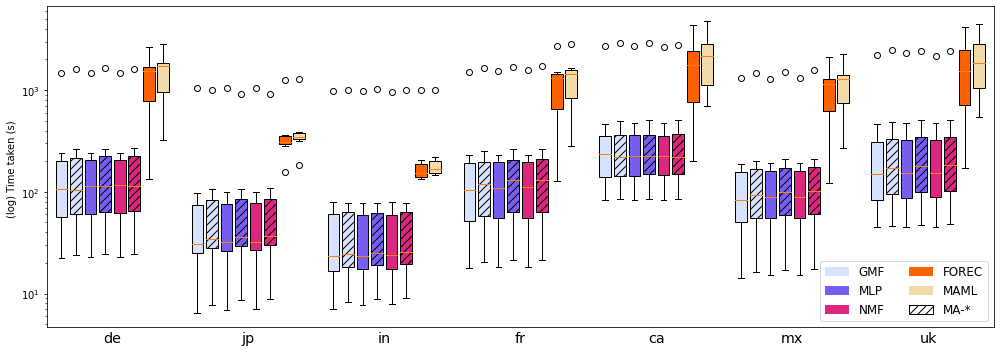

In [30]:
values = []
ticks = []
labels = []
pos = 0

group_pos_diff = .15
within_pos_diff = 0.11
width = 0.09

colors = []
color_map = {
    "gmf": "#D7E2FF",
    "mlp": "#785EF0",
    "nmf": "#DC267F",
    "FOREC": "#FE6100",
    "MAML": "#F3DBA7"
}
hatches = []
box_pos = []
hatch_ptn = "///"

for mkt in TGT:
    ticks_ = [] 
    # TODO, single model x tick 
    for model in ["gmf", "mlp", "nmf"]:
        r = row_select({"method": model, "arg_tgt_market": mkt}, base)
        assert r.shape[0] == 7
        
        values.append(r["time_taken"].values)
        #labels.append(f"{mkt}-{method_key[model]}")
        ticks_.append(pos)
        colors.append(color_map[model])
        hatches.append("")
        
        # single market tick
        r = row_select_single({"method": model, "arg_tgt_market": mkt}, single)
#         single_ticks.append((pos, r["time_taken"]))
        
        pos += within_pos_diff
        
        
        r = row_select({"method": model, "arg_tgt_market": mkt}, base_market_aware)
        assert r.shape[0] == 7
        
        values.append(r["time_taken"].values)
        #labels.append(f"{mkt}-MA-{method_key[model]}")
        ticks_.append(pos)
        colors.append(color_map[model])
        hatches.append(hatch_ptn)
        pos += within_pos_diff
    
    
    
    maml_r = row_select({"arg_tgt_market": mkt}, maml)
    assert maml_r.shape[0] == 7
    values.append(maml_r["time_taken"].values)
    #labels.append(f"{mkt}-MAML")
    ticks_.append(pos)
    colors.append(color_map["FOREC"])
    hatches.append("")
    pos += within_pos_diff
    
    
    
    # MAML+FOREC
    forec_r = row_select({"arg_tgt_market": mkt}, forec)
    forec_vals = []
    for _, r in forec_r.iterrows():    
        r_maml = maml_r[maml_r["arg_aug_src_market"] == r["arg_aug_src_market"]].to_dict(orient="records")[0]
        time_taken = r_maml["time_taken"] + r["time_taken"]
        
        # time for FOREC = time for MAML + forec
        forec_vals.append(time_taken)
        
    
    values.append(forec_vals)
    assert len(forec_vals) == 7
    #labels.append(f"{mkt}-MAML+FOREC")
    ticks_.append(pos)
    colors.append(color_map["MAML"])
    hatches.append("")
    pos += within_pos_diff

    
    ticks.append(np.mean(ticks_))
    box_pos.extend(ticks_)
    labels.append(mkt)
    
    

    pos += group_pos_diff
    


    
plt.figure(figsize=(14,5))

bplot = plt.boxplot(values, patch_artist=True, widths=width, positions=box_pos)


plt.yscale("log")

for patch, color, hatch in zip(bplot['boxes'], colors, hatches):
    patch.set_hatch(hatch)
    patch.set_facecolor(color)
    


plt.xticks(ticks=ticks, labels=labels, rotation=0, fontsize="x-large")
plt.tick_params(axis='x', length = 0)



plt.ylabel("(log) Time taken (s) ")

plt.tight_layout()
from matplotlib.patches import Patch

legend_elements = []
for lab, colorcode in color_map.items():
    kwargs = {
        "facecolor": colorcode
    }
    if lab in method_key:
        kwargs["label"] = method_key[lab]
        
        legend_elements.append(Patch(**kwargs))
    else:
        kwargs["label"] = lab
        legend_elements.append(Patch(**kwargs))

legend_elements.append(Patch(facecolor="white", edgecolor="black", hatch=hatch_ptn, label="MA-*"))

    
plt.legend(handles=legend_elements, fontsize="large", loc="lower right", ncol=2)


plt.xlim(0 - within_pos_diff, pos - group_pos_diff)
plt.savefig("results/plots/time_taken.png", dpi=600)


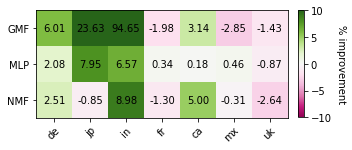

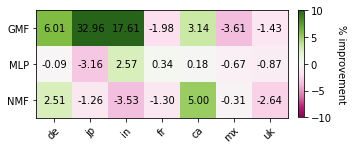

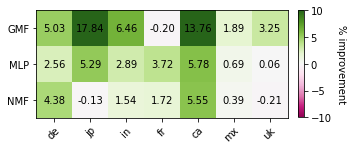

In [31]:
def heatmap_numbers(matrix, x_ticks, y_ticks,
                    figsize=(5, 3),vmax=None, vmin=None,
                    x_label=None, y_label=None,
                    title=None, cbarlabel=None, save=None):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(matrix, cmap="PiYG",
                   vmin=vmin, vmax=vmax)
    
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.02, pad=0.04)
    if cbarlabel:
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(x_ticks)), labels=x_ticks)
    ax.set_yticks(np.arange(len(y_ticks)), labels=y_ticks)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(y_ticks)):
        for j in range(len(x_ticks)):
            text = ax.text(j, i, f"{matrix[i, j]:.2f}",
                           ha="center", va="center", color="black")
    
    if title:
        ax.set_title(title)
    
    if x_label:
        ax.set_xlabel(x_label)
    
    if y_label:
        ax.set_ylabel(y_label)

    fig.tight_layout()
    
    if save:
        plt.savefig(save)
    else:
        plt.show()

    
os.makedirs("results/plots/", exist_ok=True)

for metric in ["ndcg_cut_10_mean"]:
    for setting, df, ma_df in [("FixUS", base_us, base_market_aware_us),
                              ("Best-Src", base_best, base_market_aware_best),
                              ("Avg-Src", base_avg, base_market_aware_ave)]:
        matrix = []
        x_ticks = []
        for model in single["method"].unique():

                mat_row = []
                for tgt in TGT:
                    row = row_select({"method": model, "arg_tgt_market": tgt, "exp_type": "base"}, df)

                    row = row.to_dict(orient="records")
                    assert len(row) == 1
                    row = row[0]
                    met = row[metric]

                    row_ma = row_select({"method": model, "arg_tgt_market": tgt, "exp_type": "base"}, ma_df)
                    row_ma = row_ma.to_dict(orient="records")
                    assert len(row_ma) == 1
                    row_ma = row_ma[0]

                    met_ma = row_ma[metric]

                    improvement = ((met_ma-met)/met)*100
                    mat_row.append(improvement)

                matrix.append(mat_row)
                x_ticks.append(method_key[model])
        
    
        heatmap_numbers(np.array(matrix),
                        TGT, x_ticks,
                        vmax=10,
                        vmin=-10,
                        title=None, 
                        cbarlabel="% improvement",
                        save=f"results/plots/imprv_{metric}_{setting}.png")

## Single Model Experiments

In [32]:
res = io.load_json("./raw_results/forec_single_model/maml-forec_single_model_concat.json")

In [33]:
res2 = io.load_json("./raw_results/forec_single_model/base-forec_single_model_concat.json")
for m in TGT:
    print(m, len(res2["nmf"][m]["test"]["ind"]))

de 2373
jp 487
in 239
fr 2396
ca 5675
mx 1878
uk 4847


In [34]:
GLOBAL_RESULTS_KEY = ["experiment_type", 'method', 'arg_tgt_market', 'data_sampling_method']
def global_model_key(row, market_aware=False):
    key = "_".join([row.get(_, "NA") for _ in GLOBAL_RESULTS_KEY])
    if market_aware:
        key += "_market_aware"
    return key

folder = os.path.join("raw_results", "forec_single_model")
global_user_level_results = {}

results = []
for f in os.listdir(folder):
    
    res = io.load_json(os.path.join(folder, f))
    if f.startswith("forec"):
        args = {v: res["args"][v] for v in ["data_sampling_method", "experiment_type"]}
        args["market_aware"] = False
        
        for mkt in res["args"]["markets"].split(","):
            row = args.copy()
            row["method"] = "forec"
            row["arg_tgt_market"] = mkt
            

            ulevel = {}
            for met in metrics_sel:
                mean = res[mkt]["test"]["agg"][met]["mean"]
                std = res[mkt]["test"]["agg"][met]["std"]
                row[met] = f"{mean:.2f} ({std:.2f})"
                row[f"{met}_mean"] = mean
                ulevel[met] = {uid:_[met] for uid,_ in res[mkt]["test"]["ind"].items()}
            
            row["time_taken"] = res[mkt]["train_time"]
            row["src"] = f
            
            key = global_model_key(row, market_aware=False)
            assert key not in global_user_level_results, key
            global_user_level_results[key] = ulevel
            row["key"] = key
            results.append(row)
        
    else:
        args = {v: res["args"][v] for v in ["market_aware", "data_sampling_method", "experiment_type"]}
    
        if "fast_lr" in res["args"].keys():
                # MAML model
                rr = res["nmf"]

                for split in ["test"]:
                    for mkt in res["args"]["markets"].split(","):
                        row = args.copy()
                        row["method"] = "nmf_maml"
                        row["arg_tgt_market"] = mkt

                        ulevel = {}
                        for met in metrics_sel:
                            mean = rr[f"{split}_{mkt}_step0"]["agg"][met]["mean"]
                            std = rr[f"{split}_{mkt}_step0"]["agg"][met]["std"]
                            row[met] = f"{mean:.2f} ({std:.2f})"
                            row[f"{met}_mean"] = mean
                            ulevel[met] = {uid:_[met] for uid,_ in rr[f"{split}_{mkt}_step0"]["ind"].items()}
                        
                        
                        key = global_model_key(row, market_aware=False)
                        assert key not in global_user_level_results, key
                        global_user_level_results[key] = ulevel
                        row["time_taken"] = res["nmf"]["train_time"]
                        row["src"] = f
                        row["key"] = key
                        results.append(row)
        else:
            for method in ["gmf", "mlp", "nmf"]:

                for market in res["args"]["markets"].split(","):
                    rr = res[method][market]["test"]
                    row = args.copy()
                    row["arg_tgt_market"] = market
                    row["method"] = method
                    ulevel = {}
                    for met in metrics_sel:
                        mean, std = rr["agg"][met]["mean"], rr["agg"][met]["std"]
                        row[met] = f"{mean:.2f} ({std:.2f})"
                        row[f"{met}_mean"] = rr["agg"][met]["mean"]
                        ulevel[met] = {uid:_[met] for uid,_ in res[method][market]["test"]["ind"].items()}

                    row["time_taken"] = res[method]["train_time"]
                    
                    key = global_model_key(row, market_aware=args["market_aware"])
                    assert key not in global_user_level_results, key
                    global_user_level_results[key] = ulevel
                    row["key"] = key
                    results.append(row)
        
single_model = pd.DataFrame(results)
assert len(global_user_level_results) == len(single_model)

In [35]:
def sig_test_global(df, user_level, model, cmp_model, 
                    data_sampling, tgt_market, metric, 
                    corrections=1, p_value=0.05):

    # gather MA model info
    key = row_select_single({"method": model, "arg_tgt_market": tgt_market,
                             "data_sampling_method": data_sampling, "market_aware": True}, df)["key"]

    ref_perf, ref_keys = gather_cmp(user_level[key], metric)
     
    cmpkey = row_select_single({"method": cmp_model, "arg_tgt_market": tgt_market,
                             "data_sampling_method": data_sampling, "market_aware": False}, df)["key"]

    
    assert key != cmpkey
    
    cmp_perf, cmp_keys = gather_cmp(user_level[cmpkey], metric)
    assert ref_keys == cmp_keys
    if ref_perf.mean() < cmp_perf.mean():
        return False
    
    return sig_test(ref_perf, cmp_perf, p=p_value, corrections=corrections)

global_sig_results = {}


global_corrections = 9
n = 0

for model in ["gmf", "mlp", "nmf"]:
    for metric in ["ndcg_cut_10"]:
        for tgt in TGT:
            n += 1
            r = {}
            # C1: Does MA > Non MA
            r["beats_mkt_unaware"] = sig_test_global(df=single_model, 
                                                    user_level=global_user_level_results,
                                                    model=model,
                                                    cmp_model=model,
                                                    data_sampling="concat",
                                                    tgt_market=tgt,
                                                    metric=metric,
                                                    corrections=global_corrections)
            # C2: Does MA > MAML
            r["beats_maml"] = sig_test_global(df=single_model, 
                                                    user_level=global_user_level_results,
                                                    model=model,
                                                    cmp_model="nmf_maml",
                                                    data_sampling="concat",
                                                    tgt_market=tgt,
                                                    metric=metric,
                                                    corrections=global_corrections)
            # C3: Does MA > FOREC
            r["beats_forec"] = sig_test_global(df=single_model, 
                                                    user_level=global_user_level_results,
                                                    model=model,
                                                    cmp_model="forec",
                                                    data_sampling="concat",
                                                    tgt_market=tgt,
                                                    metric=metric,
                                                    corrections=global_corrections)
            
            global_sig_results[(tgt, model, metric)] = r
    

print(n/len(TGT) * 3)

9.0


In [36]:
with open("results/single_model.tsv", "w") as writer:
    
    writer.write("Data-Augment\tMethod\tnDCG@10")
    writer.write("\t" * len(TGT))
    writer.write("\n")
    
    writer.write("\t\t")
    writer.write("\t".join(TGT))
    writer.write("\n")
    
    
    for data_sampling_method in ["concat"]:
        print(data_sampling_method)
        for model in ["gmf", "mlp", "nmf"]:
            print(model)
            writer.write(f"{data_sampling_method}\t{method_key[model]}++\t")
            write_row(writer, TGT, {"data_sampling_method": data_sampling_method, 
                                    "method": model, 
                                    "market_aware": False}, single_model)
            writer.write("\n")
            
            
            writer.write(f"{data_sampling_method}\tMA-{method_key[model]}++\t")
            write_all_row_symbols_avg(writer, model,global_sig_results, TGT, 
                                  {"data_sampling_method": data_sampling_method, 
                                    "method": model, 
                                    "market_aware": True}, single_model)
            writer.write("\n")
            
            
        
        if True:
            # NMF MAML
            writer.write(f"{data_sampling_method}\tMAML\t")
            write_row(writer, TGT, {"data_sampling_method": data_sampling_method, 
                                    "method": "nmf_maml", 
                                    "market_aware": False}, single_model)
            writer.write("\n")
            
            
            writer.write(f"{data_sampling_method}\tFOREC\t")
            write_row(writer, TGT, {"data_sampling_method": data_sampling_method, 
                                    "method": "forec", 
                                    "market_aware": False}, single_model)
            writer.write("\n")
            
            
            

concat
gmf
mlp
nmf


In [37]:
!cat results/single_model.tsv

Data-Augment	Method	nDCG@10							
		de	jp	in	fr	ca	mx	uk
concat	GMF++	0.3166	0.1781	0.4535	0.2884	0.2921	0.5245	0.4481	
concat	MA-GMF++	0.3073	0.1817	0.4554	0.2836	0.3015$^{ *}$	0.5262	0.4504	
concat	MLP++	0.3268	0.2127	0.4479	0.2953	0.3048	0.5376	0.4491	
concat	MA-MLP++	0.3158	0.2195	0.4398	0.2958	0.3178$^{ \ddagger + *}$	0.5258	0.4535	
concat	NMF++	0.3262	0.1930	0.4796	0.3030	0.2851	0.5340	0.4476	
concat	MA-NMF++	0.3442$^{ \ddagger +}$	0.2212	0.4602	0.3052	0.3112$^{ \ddagger + *}$	0.5536$^{ \ddagger *}$	0.4604$^{ \ddagger + *}$	
concat	MAML	0.3281	0.1860	0.4736	0.3022	0.2836	0.5317	0.4474	
concat	FOREC	0.3249	0.1956	0.4778	0.3033	0.2947	0.5409	0.4474	
